In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
from scipy.stats import boxcox
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score,roc_curve  
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


c:\Users\CGX\OneDrive - Teesside University\Desktop\mlProjectEnd2End\crop_recom\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Import the CSV data as Pandas DataFrame

In [2]:
df = pd.read_csv("data/Crop_recommendation.csv")

#### View Last 10 Records

In [3]:
df.tail(10)

,N,P,K,temperature,humidity,ph,rainfall,label
2190,103,40,30,27.309018,55.196224,6.348316,141.483164,coffee
2191,118,31,34,27.548230,62.881792,6.123796,181.417081,coffee
2192,106,21,35,25.627355,57.041511,7.428524,188.550654,coffee
2193,116,38,34,23.292503,50.045570,6.020947,183.468585,coffee
2194,97,35,26,24.914610,53.741447,6.334610,166.254931,coffee
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee
2199,104,18,30,23.603016,60.396475,6.779833,140.937041,coffee


### Dataset Transformation
- Transform K column 
- Removing Outliers
- Create X and y variables

#### Boxcox Transformation

In [4]:
opt_lambda = boxcox(df['K'])[1]
transformed_column = boxcox(df['K'], lmbda=opt_lambda)
transformed_column

array([2.13769277, 2.12408498, 2.14418376, ..., 2.02924344, 2.06844105,
       2.02924344])

In [5]:
df_new_K = pd.DataFrame(transformed_column)
df_new_K.skew()

0   -0.030158
dtype: float64

K Column's skewness appeared to have been significantly reduced.

In [6]:
df['K_new'] = df_new_K

#### Removing Outliers

In [7]:
#calculate z-score
z_score = (df - df.mean()) / df.std()

#identify outliers
outliers = z_score > 3

#remove outliers
df_without_outliers = df[~(z_score > 3).any(axis=1)]
df_without_outliers

,N,P,K,temperature,humidity,ph,rainfall,label,K_new
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,2.137693
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,2.124085
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,2.144184
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,2.116944
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,2.130997
...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee,2.049660
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee,1.994948
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee,2.029243
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee,2.068441


Dataset shows a reduction of 155 records after outliers were removed

Separate Dataset into X and y Variables

In [8]:
X = df_without_outliers.drop(['label', 'K'], axis=1)
y = df_without_outliers['label']

### Normalizing Dataset with StandardScaler

In [9]:
scaled = StandardScaler()
x_scaled = scaled.fit_transform(X)
x_scaled

array([[ 1.02310378, -0.26312009, -1.00891773, ...,  0.05079898,
         1.90861715,  0.56065624],
       [ 0.88930956,  0.28450979, -0.81883565, ...,  0.77247999,
         2.35800386,  0.49279075],
       [ 0.22033847,  0.18182919, -0.55549663, ...,  1.8542519 ,
         3.06483512,  0.59302845],
       ...,
       [ 1.7723514 , -0.5711619 , -0.31491913, ..., -0.13852196,
         1.34759051,  0.01979205],
       [ 1.74559255, -0.60538877,  0.14189638, ...,  0.3957951 ,
         0.47330331,  0.21528043],
       [ 1.39772759, -1.08456492, -0.42776273, ...,  0.42417091,
         0.73402618,  0.01979205]])

#### Convert the numpy array into DataFrame

In [10]:
X = pd.DataFrame(x_scaled, columns=X.columns)
X

,N,P,temperature,humidity,ph,rainfall,K_new
0,1.023104,-0.263120,-1.008918,0.501583,0.050799,1.908617,0.560656
1,0.889310,0.284510,-0.818836,0.426950,0.772480,2.358004,0.492791
2,0.220338,0.181829,-0.555497,0.515684,1.854252,3.064835,0.593028
3,0.594962,-0.502708,0.188563,0.419798,0.694669,2.665082,0.457177
4,0.701998,-0.263120,-1.168878,0.483940,1.568695,3.041212,0.527263
...,...,...,...,...,...,...,...
2040,1.478004,-0.536935,0.249071,-0.189692,0.424483,1.431929,0.121617
2041,1.263933,-1.187246,0.386178,-0.623223,-0.510327,0.487499,-0.151246
2042,1.772351,-0.571162,-0.314919,-0.153692,-0.138522,1.347591,0.019792
2043,1.745593,-0.605389,0.141896,-0.823162,0.395795,0.473303,0.215280


#### Separate dataset into train and test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=20)
X_train.shape, X_test.shape

((1370, 7), (675, 7))

### Implementing Model Training with Several Machine Learning Models

Random Forest

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9940740740740741

In [13]:
y_pred = rf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

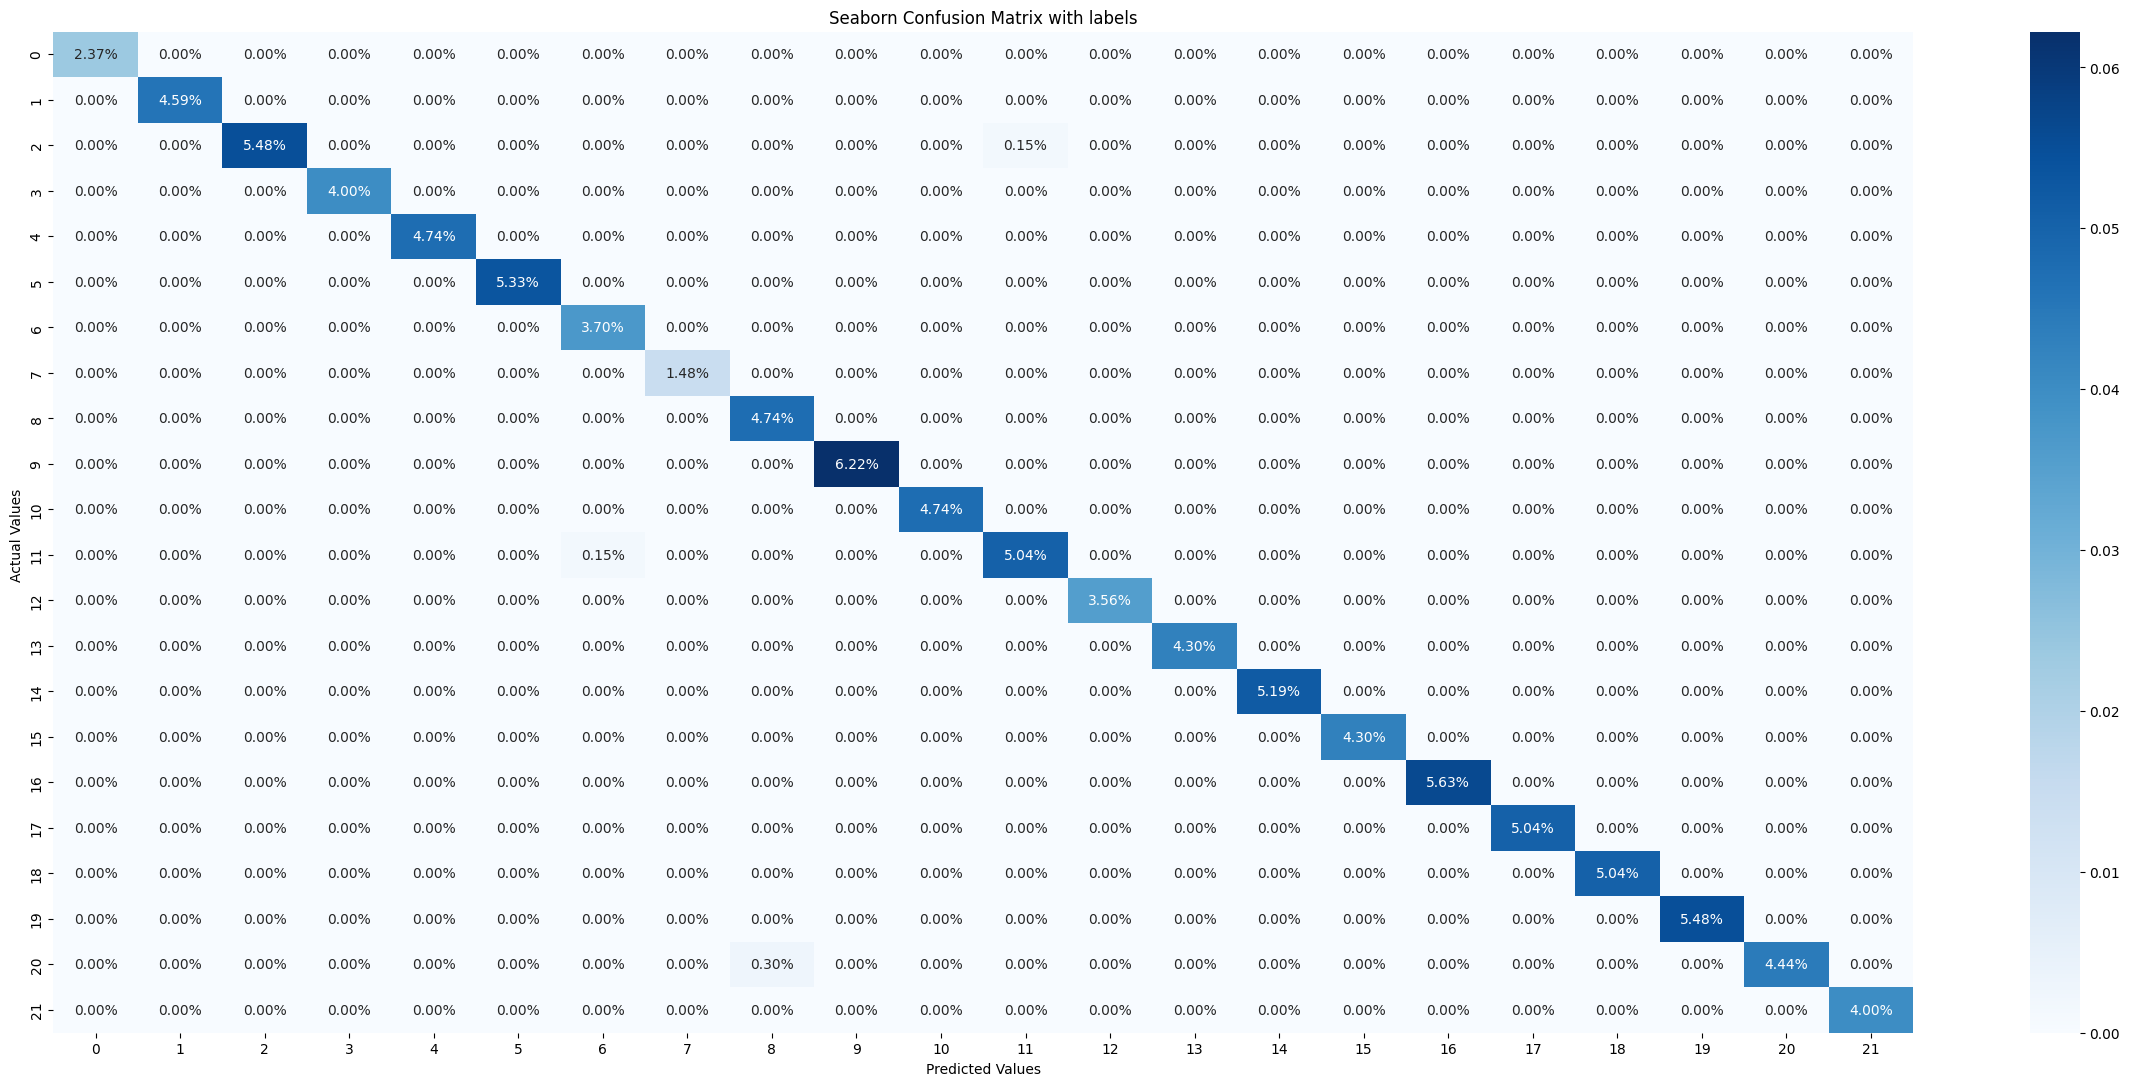

In [14]:
plt.figure(figsize=(30, 13))
ax = plt.axes()
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', ax=ax)
ax.set_title('Seaborn Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

Decision Trees

In [15]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

y_pred = dt.predict(X_test)
dt.score(X_test, y_test)

0.9851851851851852

In [16]:
y_pred = dt.predict(X_test)
cf_matrix_d = confusion_matrix(y_test, y_pred)

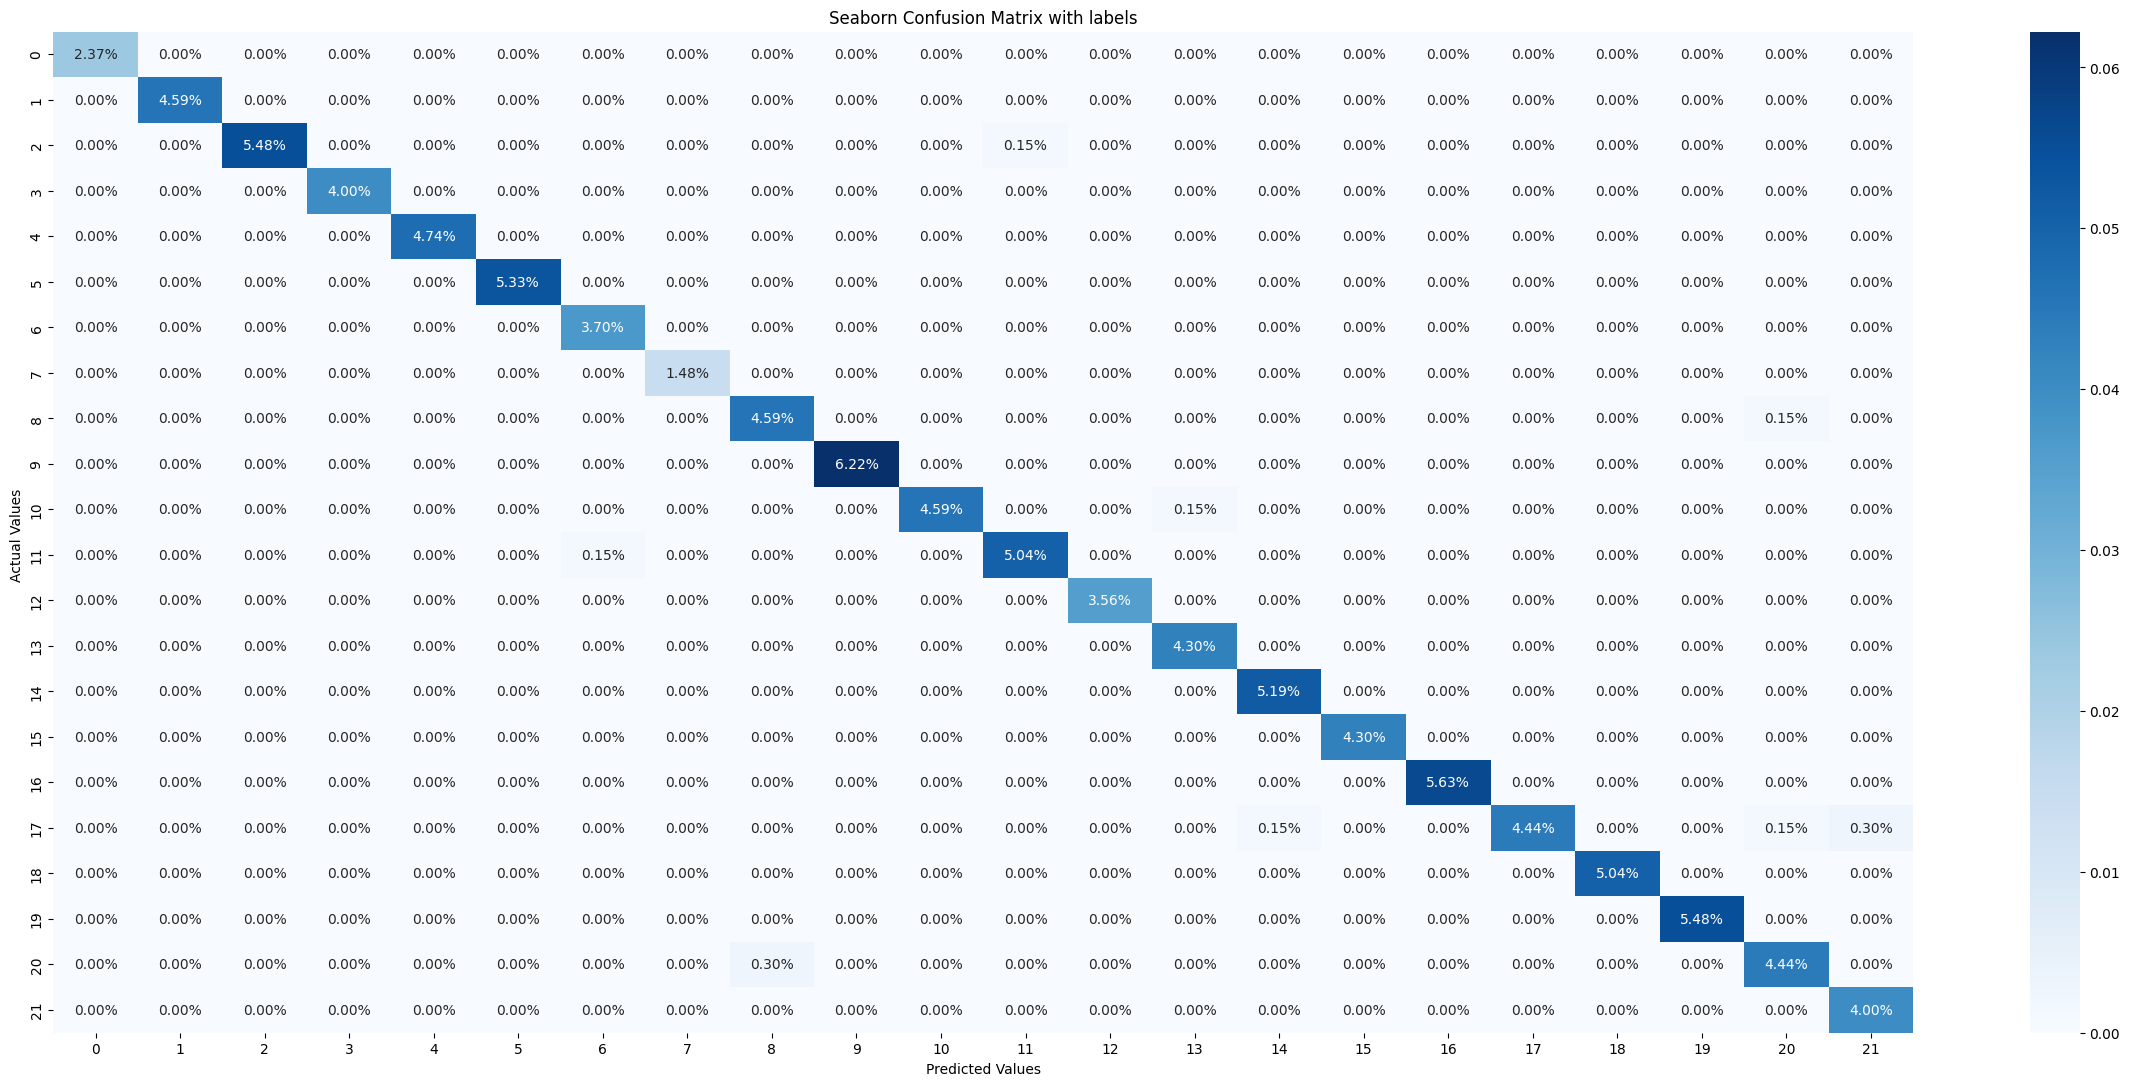

In [17]:
plt.figure(figsize=(30, 13))
ax = plt.axes()
sns.heatmap(cf_matrix_d/np.sum(cf_matrix_d), annot=True, fmt='.2%', cmap='Blues', ax=ax)
ax.set_title('Seaborn Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

Naive Bayes

In [18]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.997037037037037

In [19]:
y_pred = nb.predict(X_test)
cf_matrix_n = confusion_matrix(y_test, y_pred)

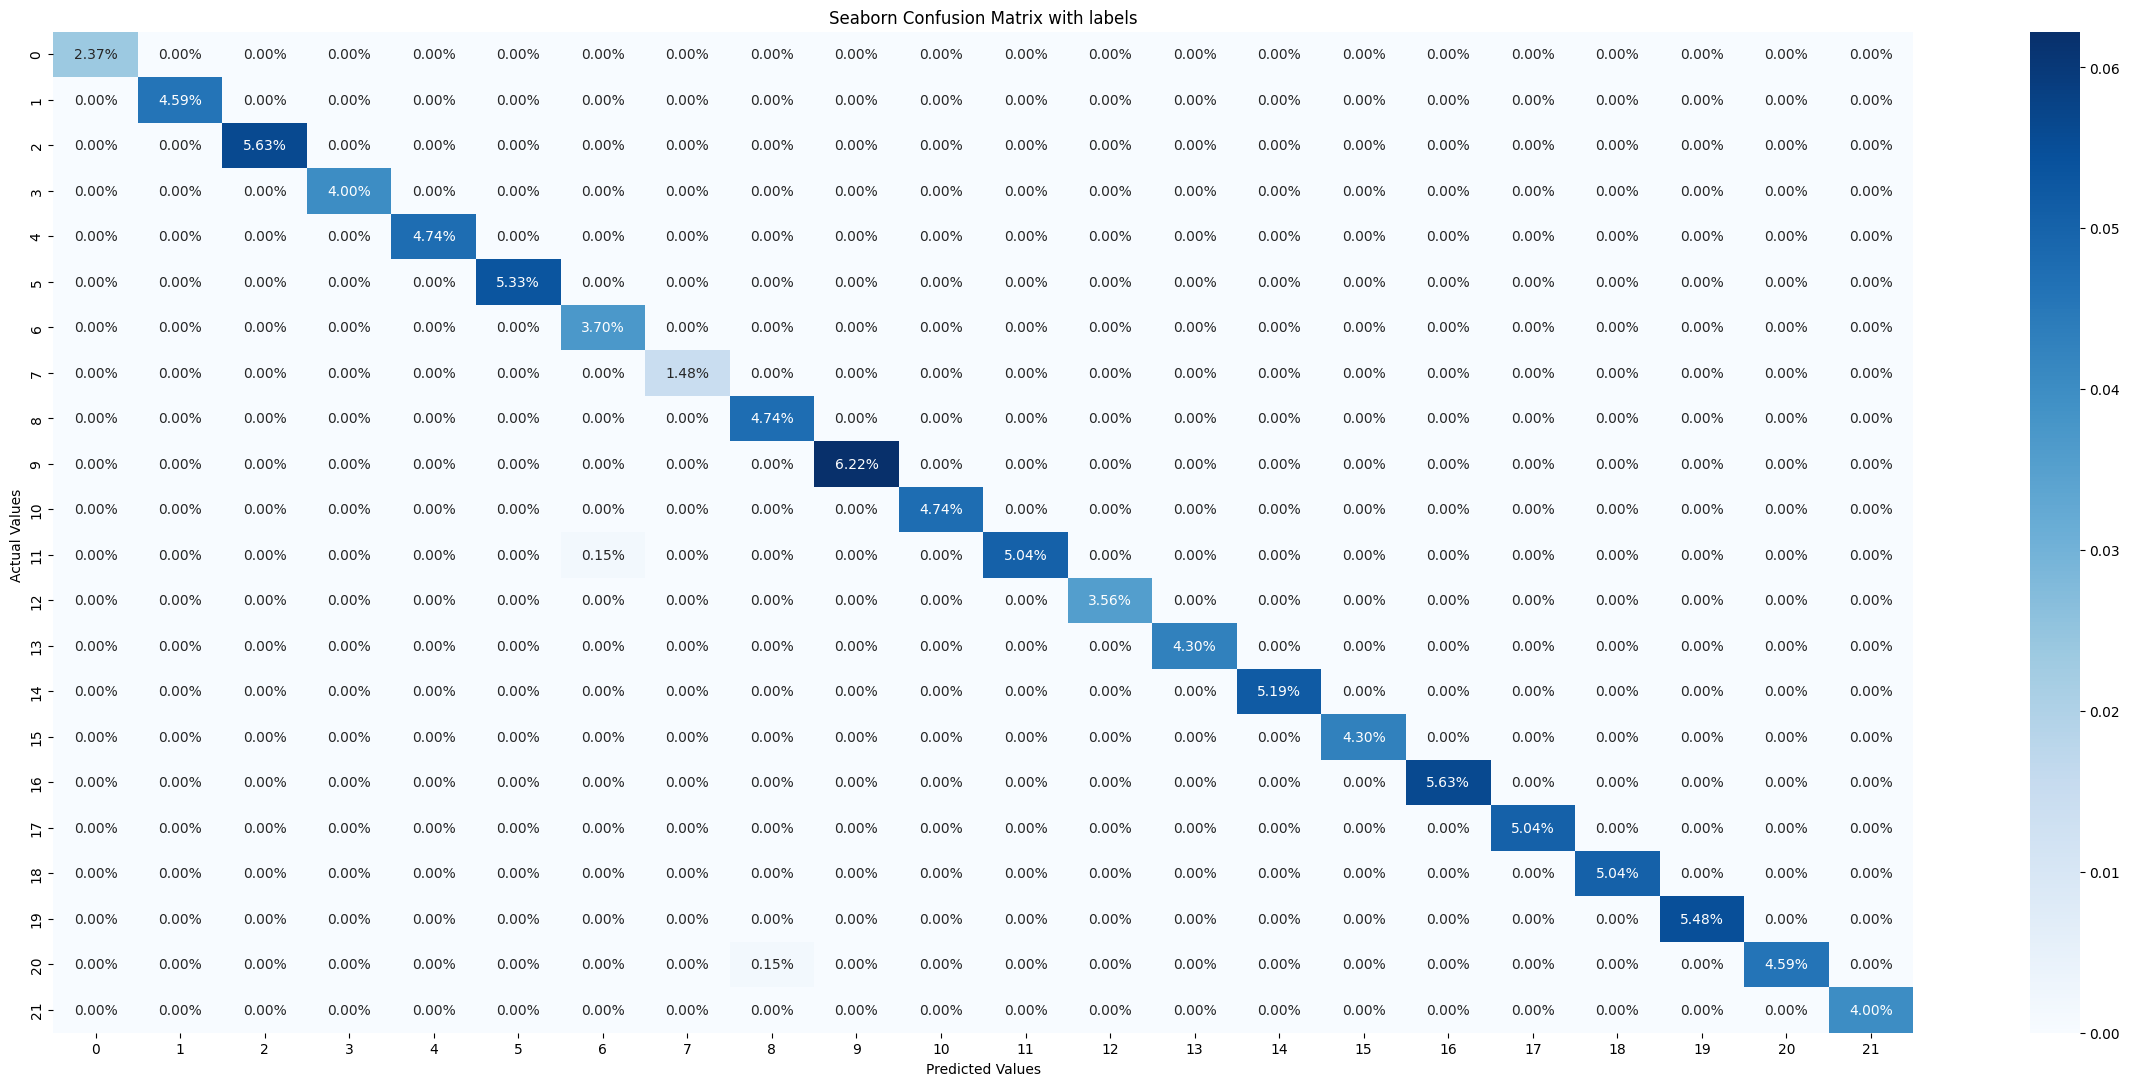

In [20]:
plt.figure(figsize=(30, 13))
ax = plt.axes()
sns.heatmap(cf_matrix_n/np.sum(cf_matrix_n), annot=True, fmt='.2%', cmap='Blues', ax=ax)
ax.set_title('Seaborn Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

XGBoost :
Encode y column for training

In [21]:
#create label encoder object
le = LabelEncoder()

#convert the categorical columns into numeric
df_without_outliers['label'] = le.fit_transform(df_without_outliers['label'])

y_encode = df_without_outliers['label']

In [22]:
X_train,X_test,y_train_encode,y_test_encode = train_test_split(X, y_encode, test_size=0.33, random_state=20)

#Fit the model
xgb = XGBClassifier()
xgb.fit(X_train, y_train_encode)

#Make predictions
y_pred = xgb.predict(X_test)

#Evaluate the model
accuracy = accuracy_score(y_test_encode, y_pred)

#Print the accuracy
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 98.96%


In [23]:
y_pred = xgb.predict(X_test)
cf_matrix_x = confusion_matrix(y_test_encode, y_pred)

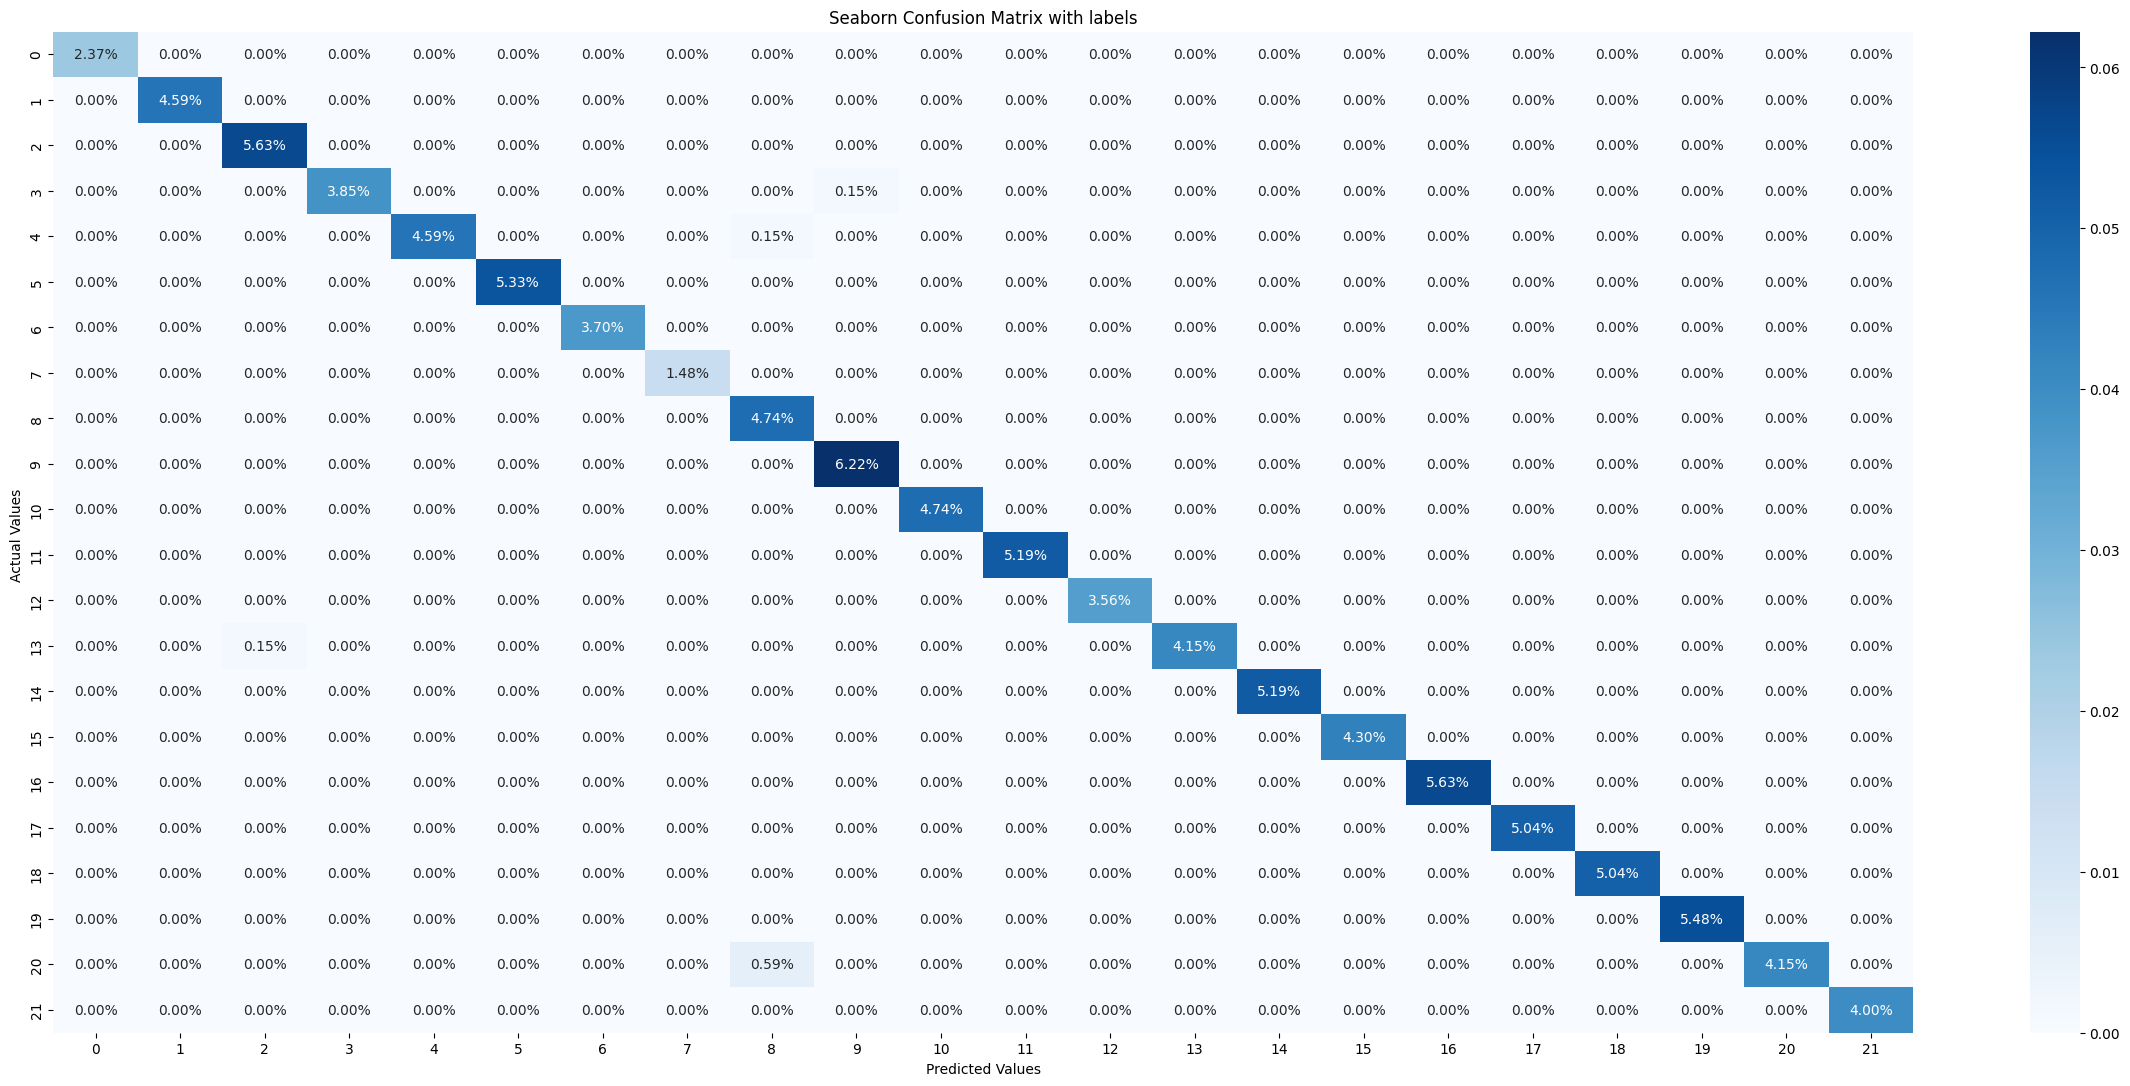

In [24]:
plt.figure(figsize=(30, 13))
ax = plt.axes()
sns.heatmap(cf_matrix_x/np.sum(cf_matrix_x), annot=True, fmt='.2%', cmap='Blues', ax=ax)
ax.set_title('Seaborn Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

Gradient Boosting Machine

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

0.9851851851851852

In [26]:
y_pred = gb.predict(X_test)
cf_matrix_g = confusion_matrix(y_test, y_pred)

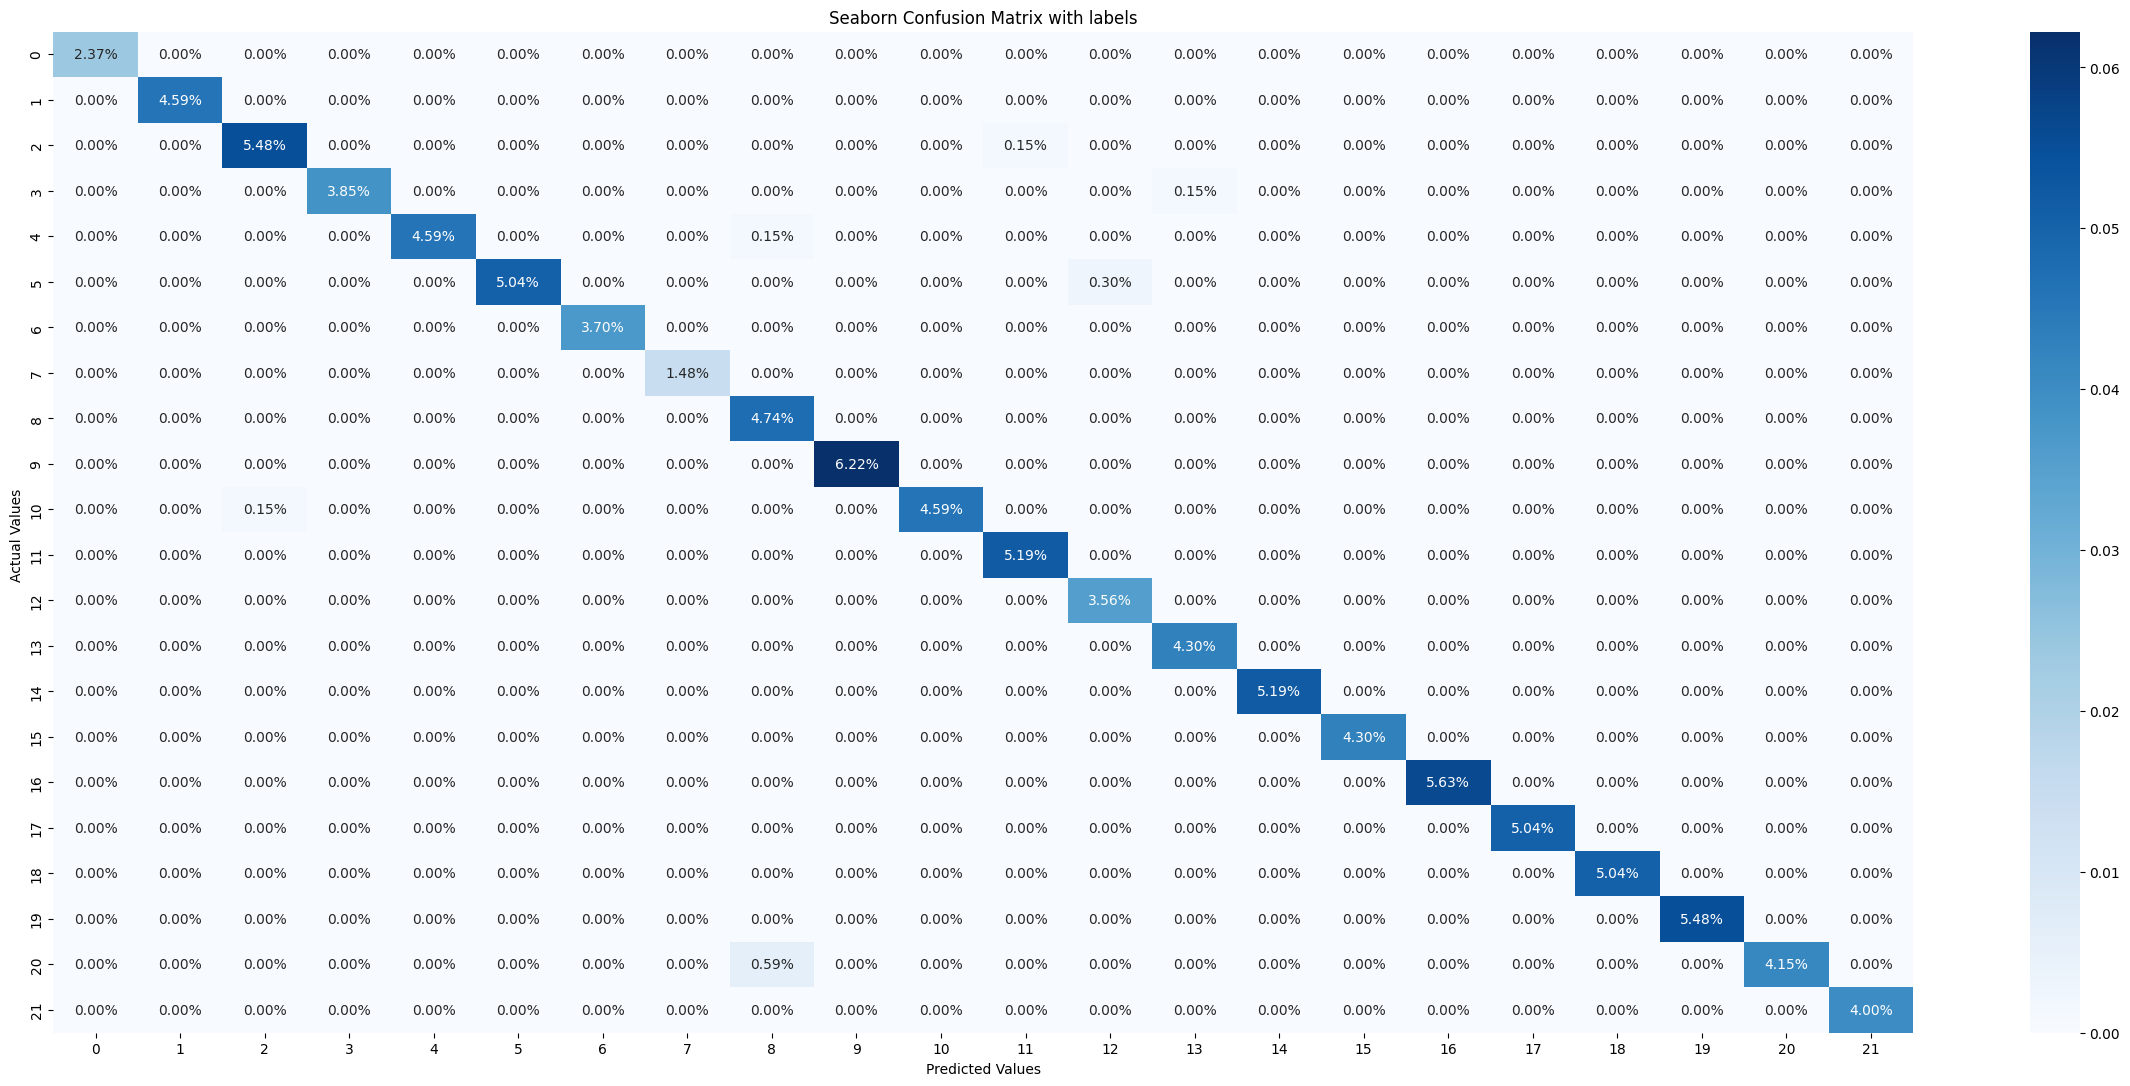

In [27]:
plt.figure(figsize=(30, 13))
ax = plt.axes()
sns.heatmap(cf_matrix_g/np.sum(cf_matrix_g), annot=True, fmt='.2%', cmap='Blues', ax=ax)
ax.set_title('Seaborn Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

K-Nearest Neighbors

In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9718518518518519

In [29]:
y_pred = knn.predict(X_test)
cf_matrix_k = confusion_matrix(y_test, y_pred)

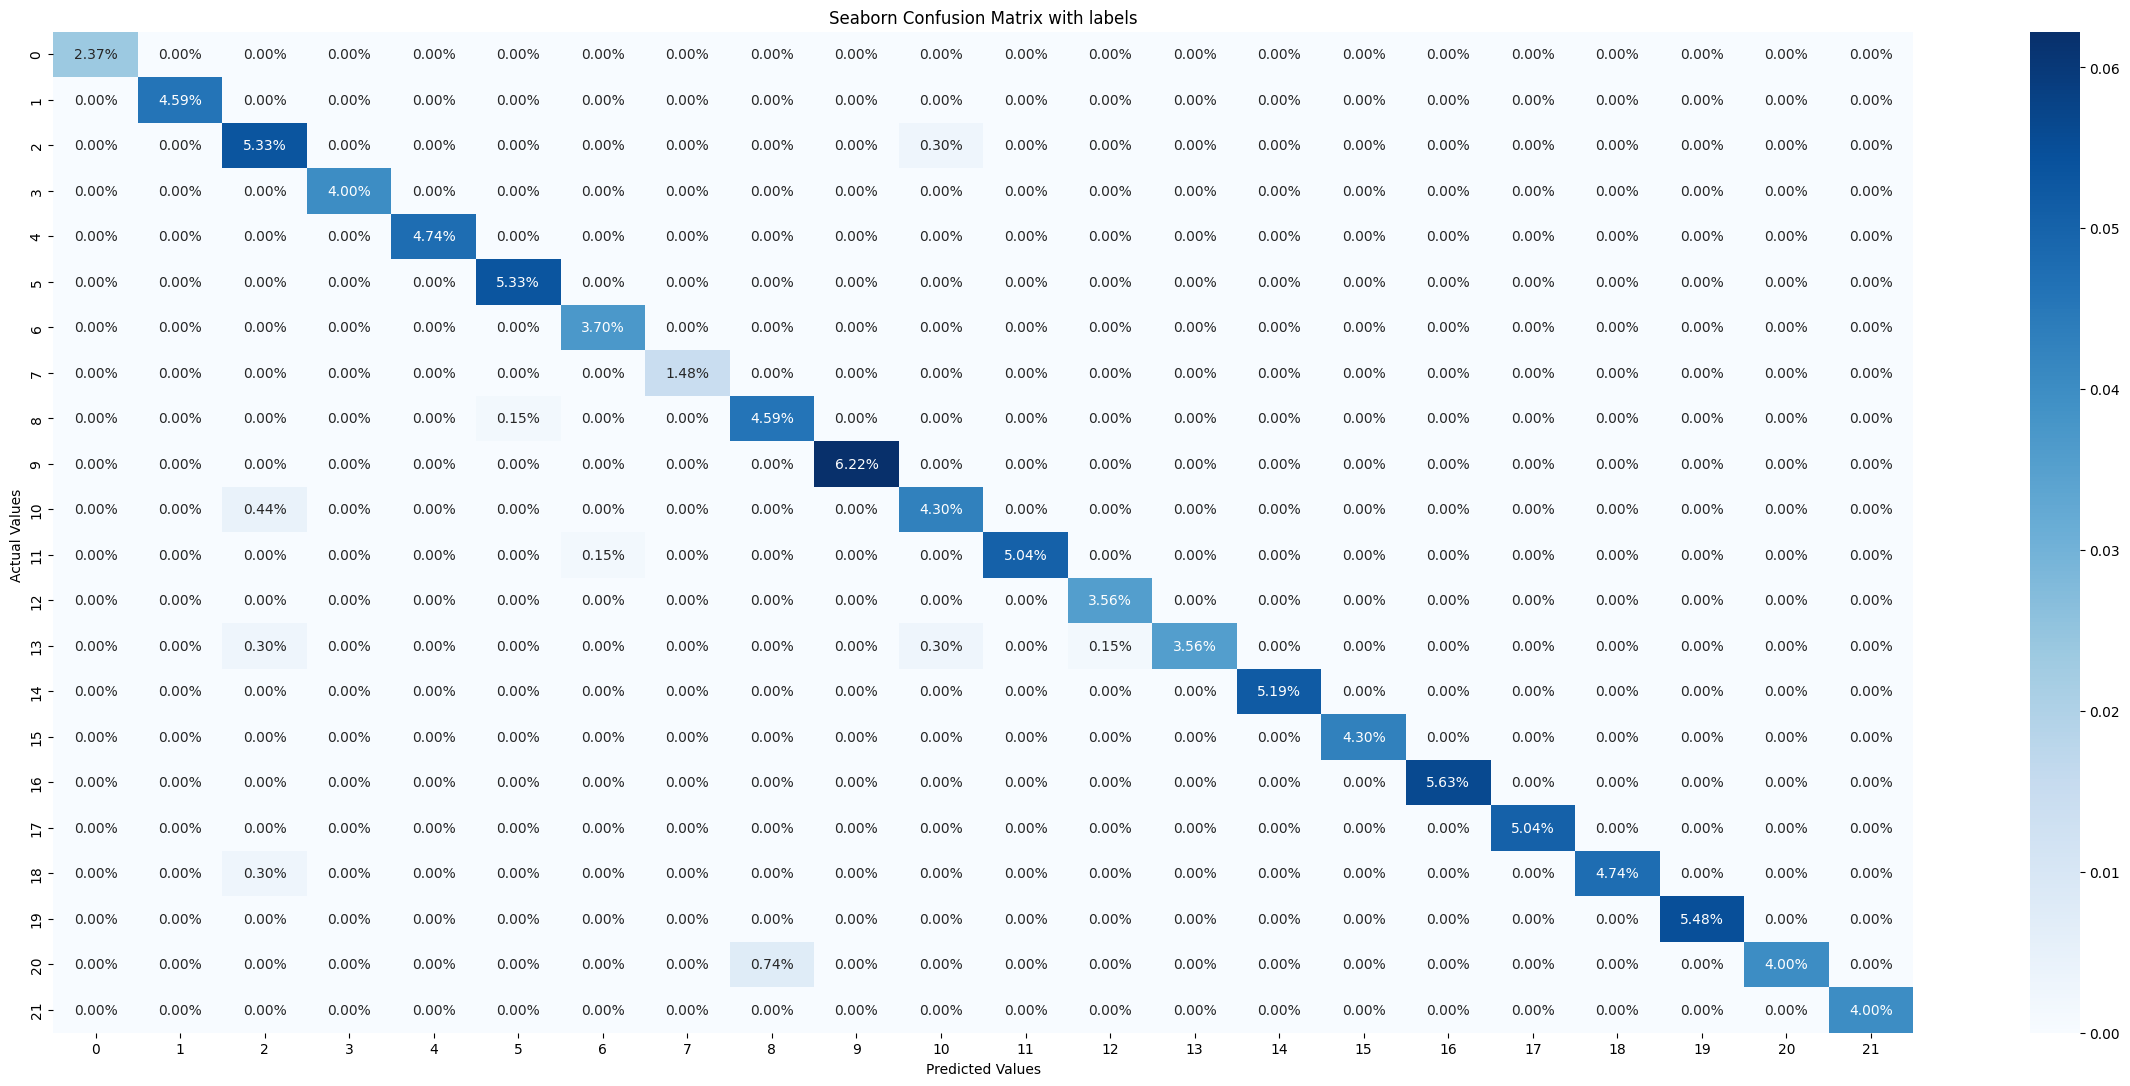

In [30]:
plt.figure(figsize=(30, 13))
ax = plt.axes()
sns.heatmap(cf_matrix_k/np.sum(cf_matrix_k), annot=True, fmt='.2%', cmap='Blues', ax=ax)
ax.set_title('Seaborn Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

Logistic Regression

In [31]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9644444444444444

In [32]:
y_pred = lr.predict(X_test)
cf_matrix_l = confusion_matrix(y_test, y_pred)

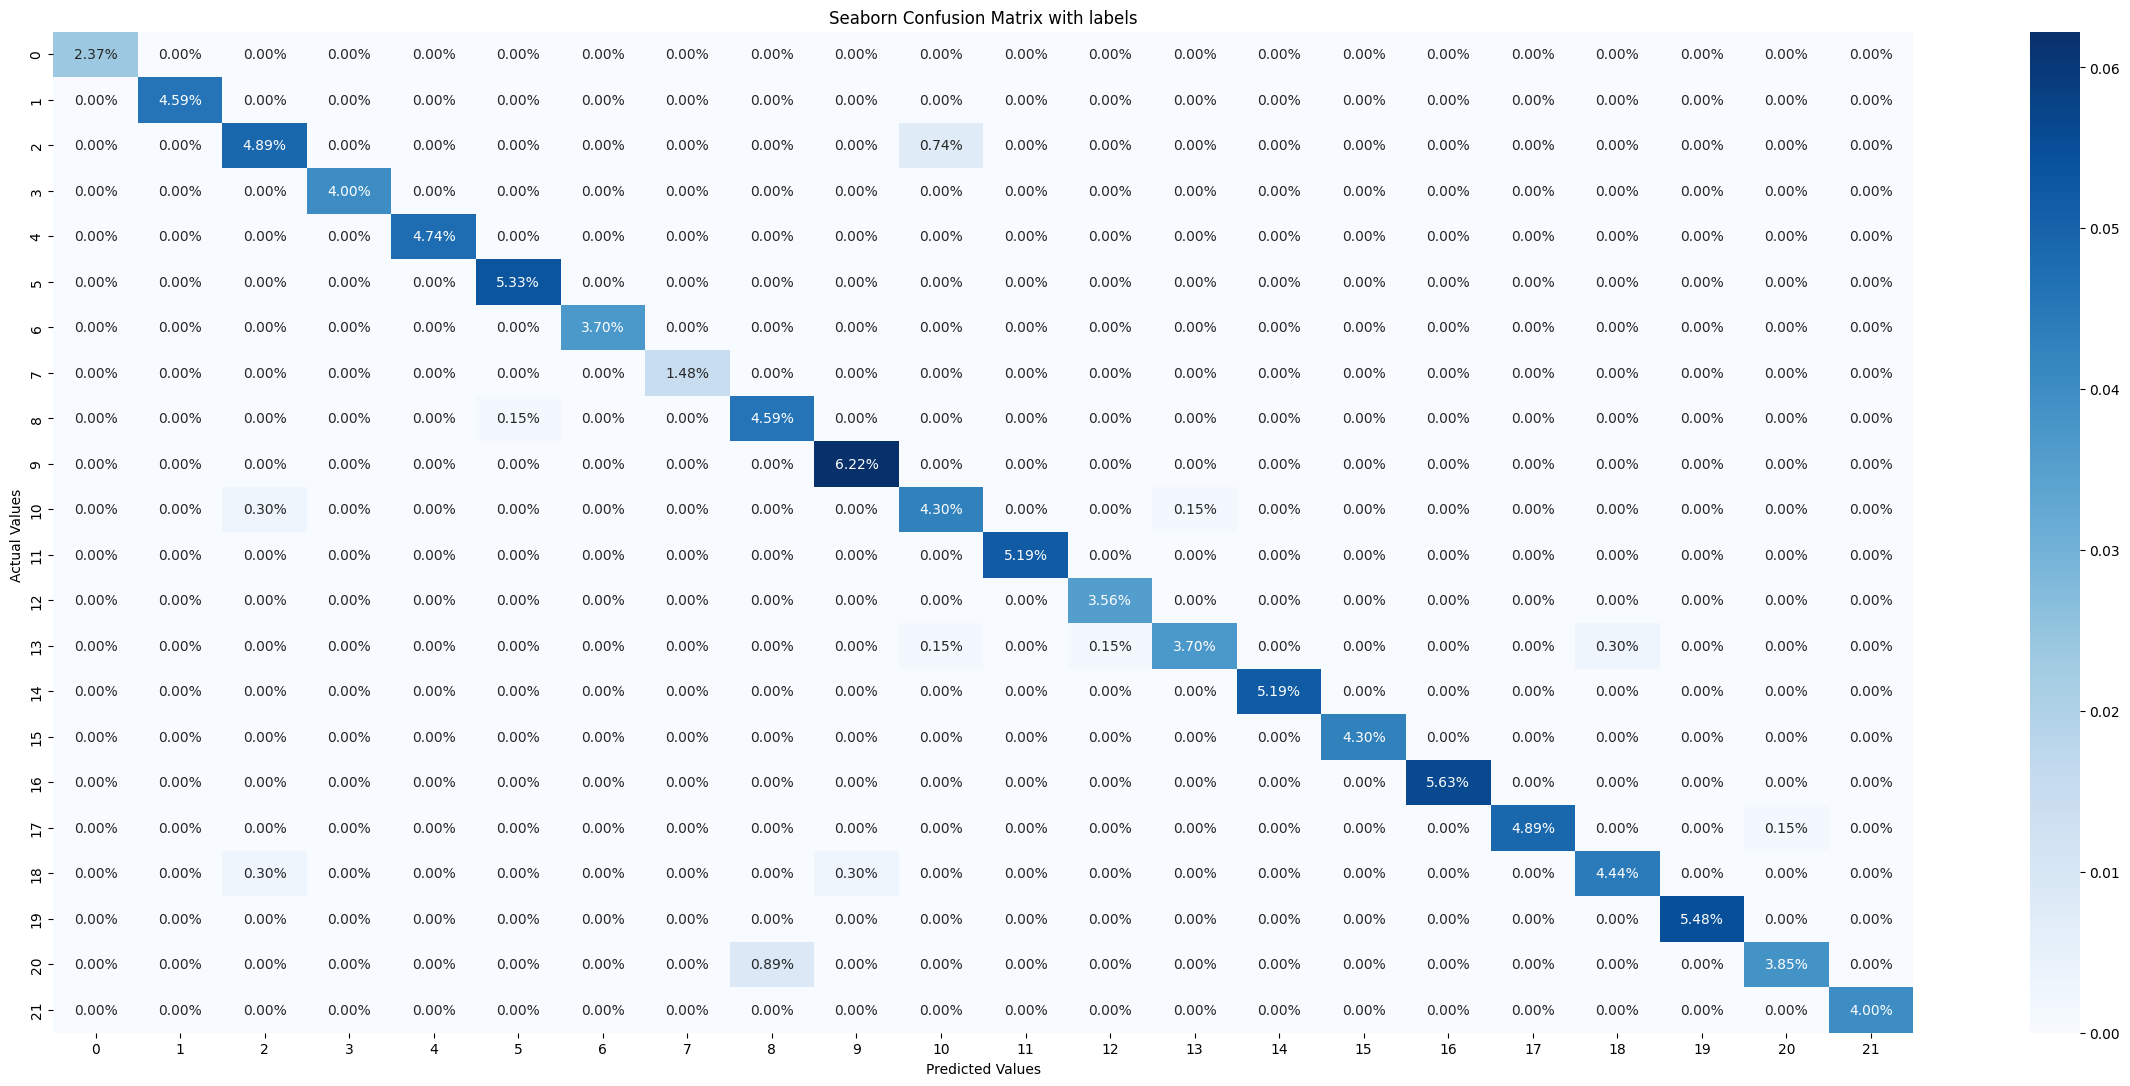

In [33]:
plt.figure(figsize=(30, 13))
ax = plt.axes()
sns.heatmap(cf_matrix_l/np.sum(cf_matrix_l), annot=True, fmt='.2%', cmap='Blues', ax=ax)
ax.set_title('Seaborn Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

Support Vector Machine

In [34]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.9777777777777777

In [35]:
y_pred = svm.predict(X_test)
cf_matrix_s = confusion_matrix(y_test, y_pred)

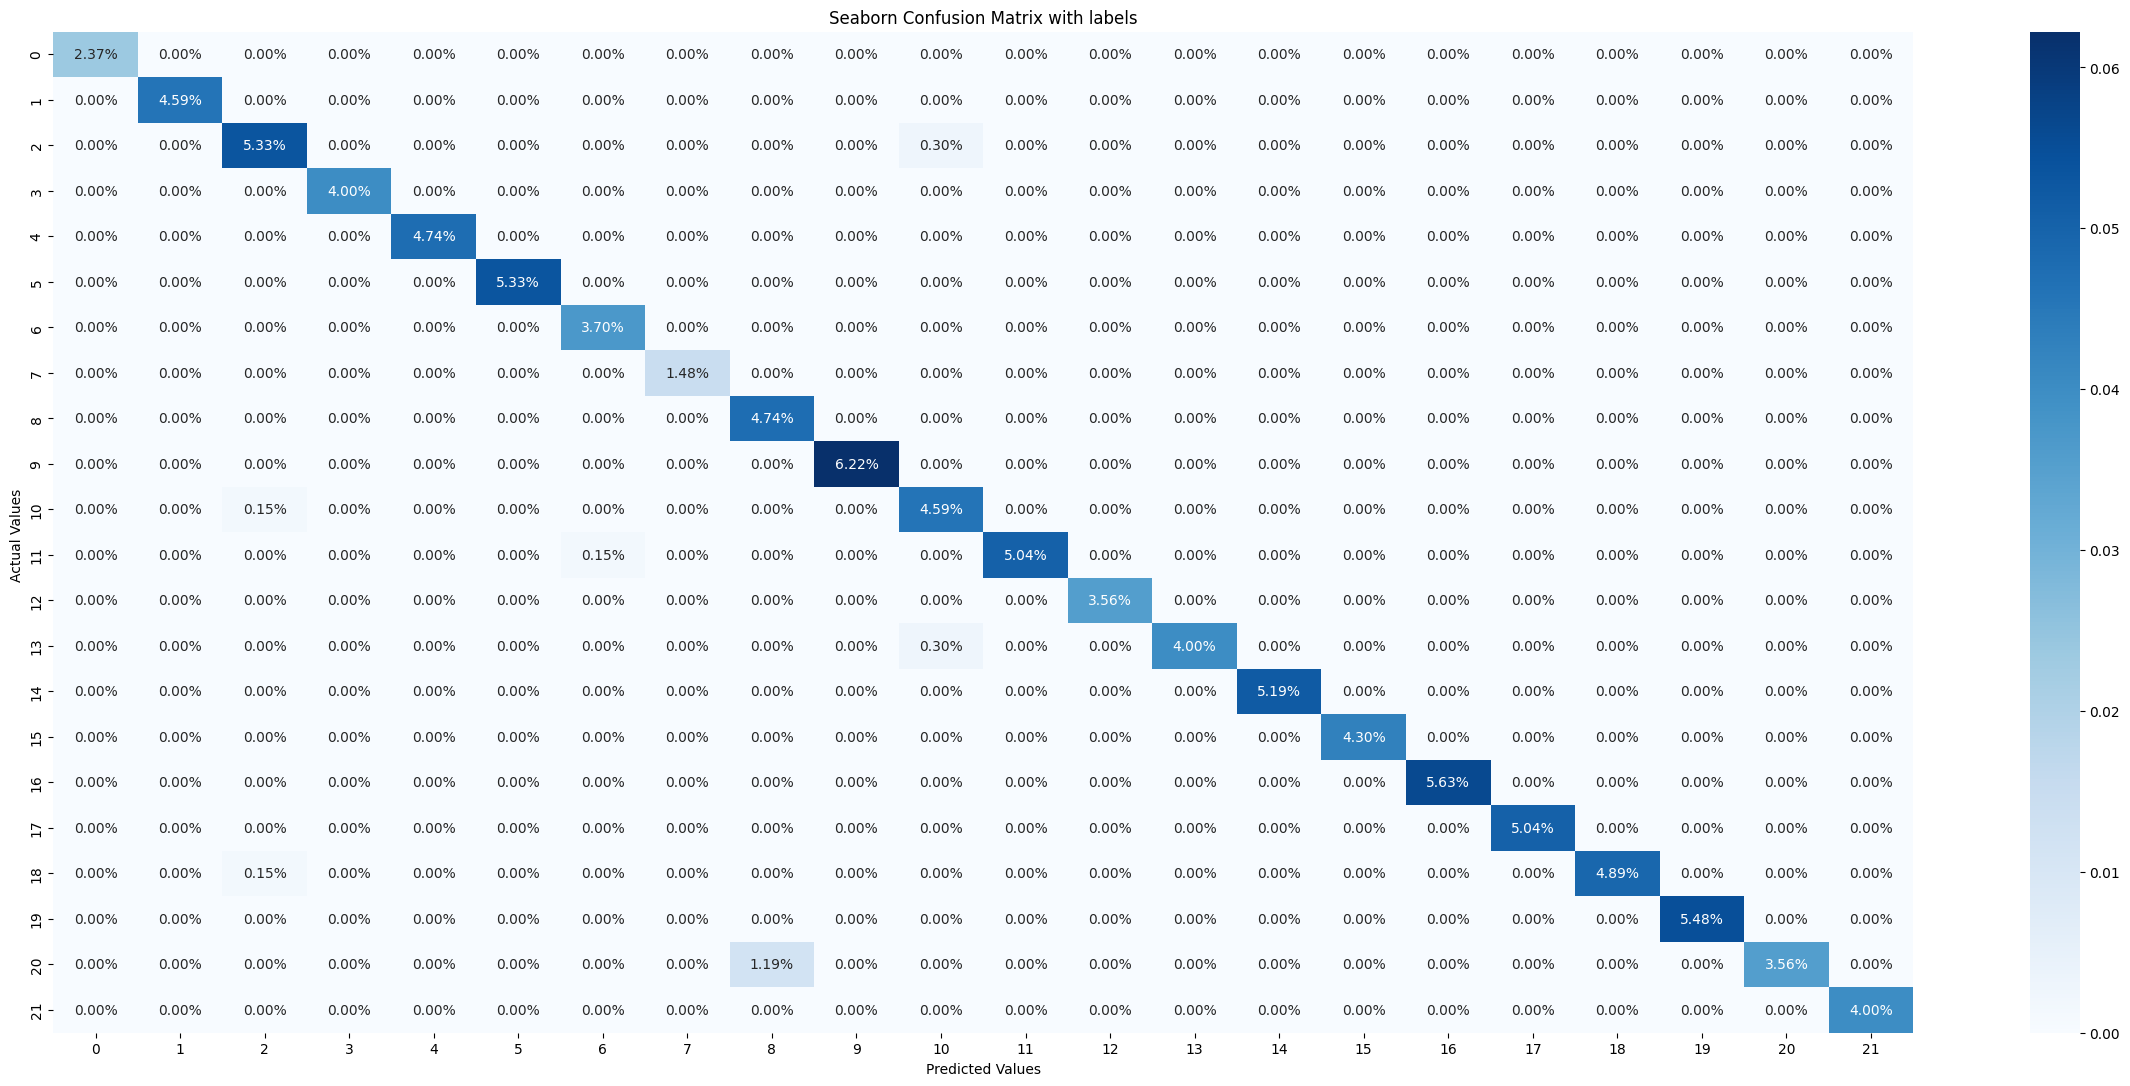

In [36]:
plt.figure(figsize=(30, 13))
ax = plt.axes()
sns.heatmap(cf_matrix_s/np.sum(cf_matrix_s), annot=True, fmt='.2%', cmap='Blues', ax=ax)
ax.set_title('Seaborn Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

#### Hyperparameter Tuning

Random Forest

In [37]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,6,8],
    'criterion' :['gini', 'entropy']
}

#Instantiate the RandomForestClassifier
rf = RandomForestClassifier()

#Setup the GridSearchCV object
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

#Fit to the data
grid_search_rf.fit(X_train, y_train)

#Print the best parameters and best score
print('Best Parameters: ', grid_search_rf.best_params_)
print('Best Score: ', grid_search_rf.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}
Best Score:  0.9926980562273665


Decision Trees

In [38]:

#Define the hyperparameters to tune 
# params = {'max_depth':[20,35,45,60], 'min_samples_split':[2,3,4,5], 'criterion':['gini','entropy']}
params = {'max_depth': range(1,20), 'min_samples_split': range(2,10), 'min_samples_leaf': range(2,10), 'criterion':['gini','entropy']}

grid_search_dt = GridSearchCV(estimator=dt, param_grid=params, cv=10, n_jobs=1, verbose=2)
grid_search_dt.fit(X_train, y_train)

#Print the best parameters
grid_search_dt.best_score_, grid_search_dt.best_params_

Fitting 10 folds for each of 2432 candidates, totalling 24320 fits
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=1, min_samples_l

(0.9868613138686131,
 {'criterion': 'gini',
  'max_depth': 16,
  'min_samples_leaf': 2,
  'min_samples_split': 4})

Naive Bayes

In [39]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5,  n_repeats=3, random_state=999)

from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=nb, param_grid=params_NB, cv=cv_method,
verbose=1, scoring='accuracy')

data_transformed = PowerTransformer().fit_transform(X_test)

gs_NB.fit(data_transformed, y_test)
gs_NB.best_params_,gs_NB.best_score_

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


({'var_smoothing': 0.0006579332246575676}, 0.9930864197530865)

Gradient Boosting Machine

In [40]:
#Execution time 20mins 12s
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

#define range of hyperparameters to tune
param_grid = {
    'learning_rate': np.arange(000.1,000.5,0.009),
    'n_estimators': np.arange(50,500,50),
    'max_depth': np.arange(1,10,1),
    'min_samples_split': np.arange(2,10,1),
    'min_samples_leaf': np.arange(1,10,1)
    }



#set up randomized search cv
random_search_gb = RandomizedSearchCV(gb, param_grid, scoring='accuracy', n_iter=25, n_jobs=-1, cv=5, random_state=42)

#train model with randomized search cv
random_search_gb.fit(X_train, y_train)

#find best parameters
best_params = random_search_gb.best_params_

#predict on test set
y_pred = random_search_gb.predict(X_test)
print(random_search_gb.best_params_,random_search_gb.best_score_)

{'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 6, 'learning_rate': 0.32499999999999984} 0.9861313868613137


Logistic Regression

In [41]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

#instantiate the grid search model
grid_search_lr = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

#fit the grid search to the data
grid_search_lr.fit(X_train,y_train)

#view the best hyperparameters
print('Best Penalty:', grid_search_lr.best_estimator_.get_params()['penalty'])
print('Best C:', grid_search_lr.best_estimator_.get_params()['C'])
print('Best Score :', grid_search_lr.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Penalty: l2
Best C: 100
Best Score : 0.9759124087591239


K-Nearest Neigbours

In [42]:
k_range = list(range(1, 31))
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
# instantiate the grid
grid_search_knn = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
# fit the grid with data
grid_search_knn.fit(X, y)
# view the complete results
grid_search_knn.cv_results_
# examine the best model
print(grid_search_knn.best_score_)
print(grid_search_knn.best_params_)

0.9780009564801532
{'n_neighbors': 5}


Support Vector Machine

In [43]:
# define parameter values 
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}

# create the grid 
grid_search_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

# fit the grid with data 
grid_search_svm.fit(X_train,y_train)

# view the results 
print(grid_search_svm.best_params_)
print(grid_search_svm.best_estimator_)
print(grid_search_svm.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.810 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.792 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.796 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.781 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.788 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.956 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.974 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.982 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.974 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.985 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.887 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

XGBoost

In [44]:
# Create Parameter Grid
param_grid = {
    "learning_rate": [0.1, 0.01],
    "max_depth": [3, 4],
    "gamma": [0, 0.5],
    "n_estimators": [100, 200]
}

# Create Grid Search CV
grid_search_xgb = GridSearchCV(xgb, param_grid, scoring="accuracy", n_jobs=-1, cv=5)

# Fit model
grid_search_xgb.fit(X_train, y_train_encode)

# Print best parameters
print("Best Score: ", grid_search_xgb.best_score_)
print("Best Parameters: ", grid_search_xgb.best_params_)

Best Score:  0.981021897810219
Best Parameters:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [52]:

#creating a dataframe
data = {'Model Name': ['Random Forest','Decision Trees','Naive Bayes','Gradient Boosting','Logistic Regression', 
                       'KNN', 'SVM', 'XGB'],
        'Best Score': [grid_search_rf.best_score_, grid_search_dt.best_score_, gs_NB.best_score_, random_search_gb.best_score_,
                       grid_search_lr.best_score_, grid_search_knn.best_score_, grid_search_svm.best_score_,
                       grid_search_xgb.best_score_]
       }

#creating a dataframe
df_hyperparameter_data = pd.DataFrame(data)

def sort_dataframe(df, column_name, ascending=True):
  return df.sort_values(by=[column_name], ascending=ascending)

In [55]:
df = sort_dataframe(df_hyperparameter_data, 'Best Score', ascending=False)
df

,Model Name,Best Score
2,Naive Bayes,0.993086
0,Random Forest,0.992698
6,SVM,0.987591
1,Decision Trees,0.986861
3,Gradient Boosting,0.986131
7,XGB,0.981022
5,KNN,0.978001
4,Logistic Regression,0.975912
